In [2]:
import pandas as pd
from utils import pca_utils, utils, pca_utils, plots
import numpy as np
from utils import plots
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture

In [6]:
def del_col_max_lt_value(df, value=20):
    for c in df:
        if df[c].max() < value:
            del df[c]

def del_col_percentile_lt_value(df, value=3):
    for c in df:
        if np.percentile(df[c], 75) < value:
            del df[c]

# Abrir arquivos

In [12]:
df_pca_temas = pd.read_csv('./output/pca/df_pca_temas.csv')
df_pca_temas.set_index(df_pca_temas['id_dep'].astype(int), inplace=True, drop=True)
del df_pca_temas['id_dep']
df_pca_temas.columns = [f"temas_{c}" for c in df_pca_temas.columns]

df_pca_tipos = pd.read_csv('./output/pca/df_pca_tipos.csv')
df_pca_tipos.set_index(df_pca_tipos['id_dep'].astype(int), inplace=True, drop=True)
del df_pca_tipos['id_dep']
df_pca_tipos.columns = [f"tipos_{c}" for c in df_pca_tipos.columns]


deputados = utils.open_json("D:/ARTIGO_ABCP/data", "deputados.json")
df_deps = pd.DataFrame(deputados)
df_deps.set_index(df_deps['id'].astype(int), inplace=True)

In [45]:
# Cluster analysis

# Cluster analysis

In [4]:
def cluster_dataframe(
    df,
    techniques=["kmeans", "dbscan", "gmm"],
    k_value=3,
    eps=0.5,
    min_samples=5,
):
    """
    Clusters the input DataFrame using k-means, DBSCAN, and GMM algorithms.

    Args:
        df (pd.DataFrame): The DataFrame to be clustered.
        k_value (int, optional): Number of clusters for k-means. Defaults to 3.
        eps (float, optional): Maximum distance between two samples for DBSCAN. Defaults to 0.5.
        min_samples (int, optional): Minimum number of samples in a neighborhood for DBSCAN. Defaults to 5.

    Returns:
        pd.DataFrame: The original DataFrame with added columns for cluster labels from each algorithm.
    """

    df_c = df.copy()

    # K-means
    if "kmeans" in techniques:
        kmeans = KMeans(n_clusters=k_value, random_state=0).fit(df)
        df_c["k_means_cluster"] = kmeans.labels_

    # DBSCAN
    if "dbscan" in techniques:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(df)
        df_c["dbscan_cluster"] = dbscan.labels_

    # Gaussian Mixture Model (GMM)
    if "gmm" in techniques:
        gmm = GaussianMixture(n_components=k_value, random_state=0).fit(df)
        df_c["gmm_cluster"] = gmm.predict(df)

    return df_c


def melt_df(df, val_columns, cluster_column="Cluster"):
    # Melt the DataFrame
    df_melted = df.reset_index().melt(
        id_vars=["id_dep", cluster_column],  # Keep these as identifier columns
        value_vars=val_columns,
        var_name="var",
        value_name="value",
    )

    df_melted["value"] = df_melted["value"].astype(float)

    return df_melted


def plot_melted_df(df_melted, hue_col="Cluster", figsize=(12, 8), xticks_rotation=45):
    # Set the desired figure size (width, height) in inches
    plt.figure(figsize=figsize)

    # Create the Seaborn boxplot
    sns.boxplot(data=df_melted, x="var", y="value", hue=hue_col)

    # Optional: Adjust layout for better readability (especially with many boxes)
    plt.xticks(rotation=xticks_rotation, ha="right")  # Rotate x-axis labels if needed

    # Show the plot
    plt.tight_layout()
    plt.show()

## Cluster temas

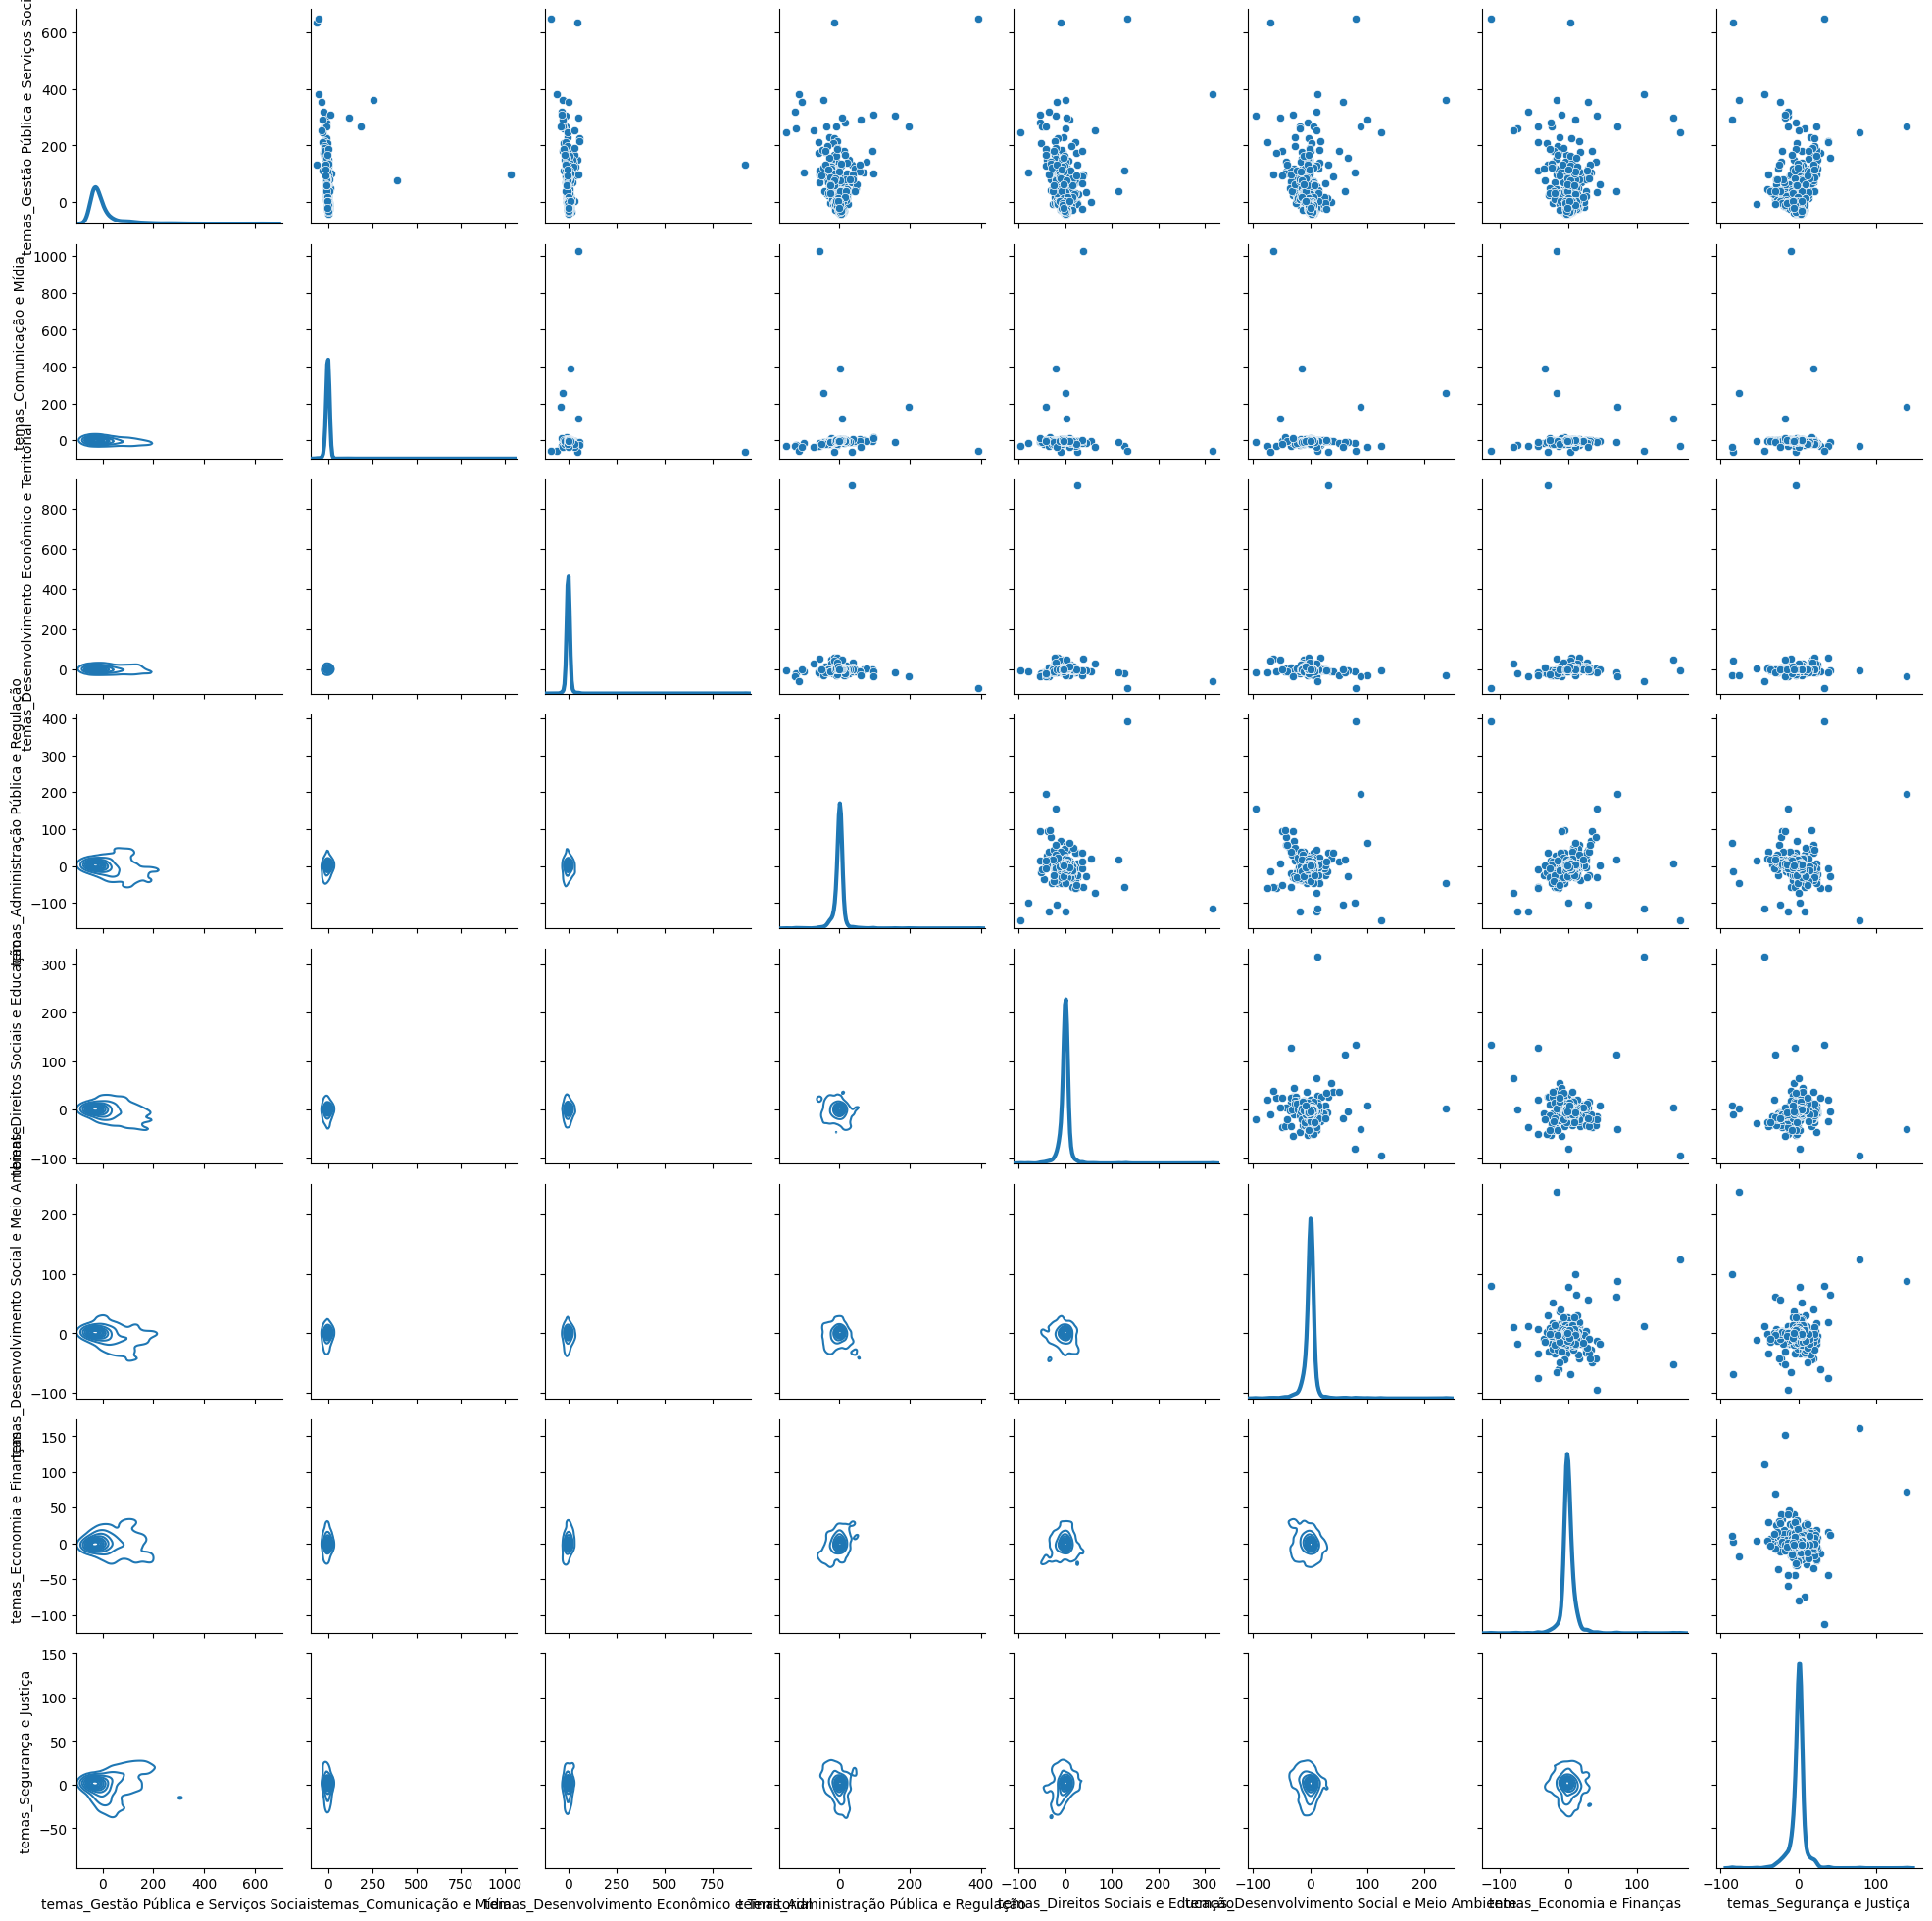

In [90]:
g = sns.PairGrid(df_pca_temas)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False)

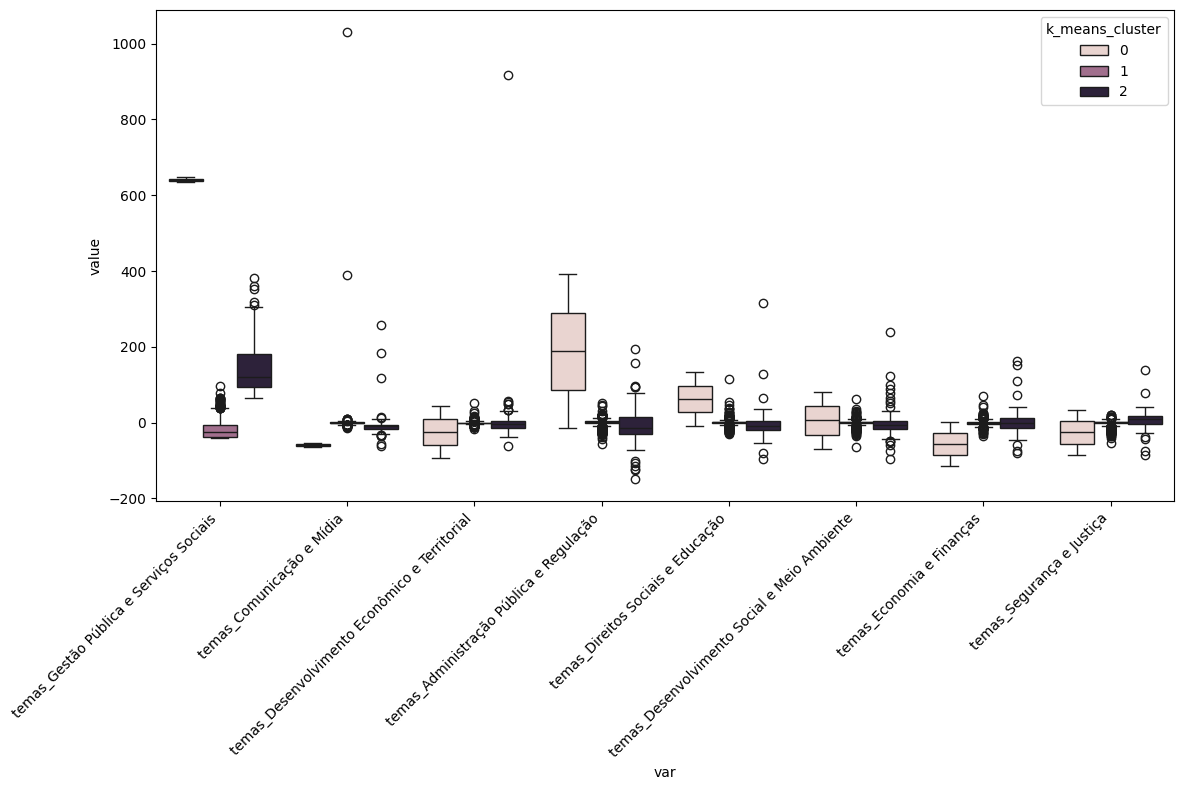

In [62]:
df_cluster = cluster_dataframe(df_pca_temas)

cols = ["k_means_cluster"] #"gmm_cluster, "dbscan_cluster",
for col in cols:
    df_c_melted = melt_df(df_cluster, val_columns=df_pca_temas.columns, cluster_column=col)
    plot_melted_df(df_c_melted, hue_col=col)

## Cluster tipos

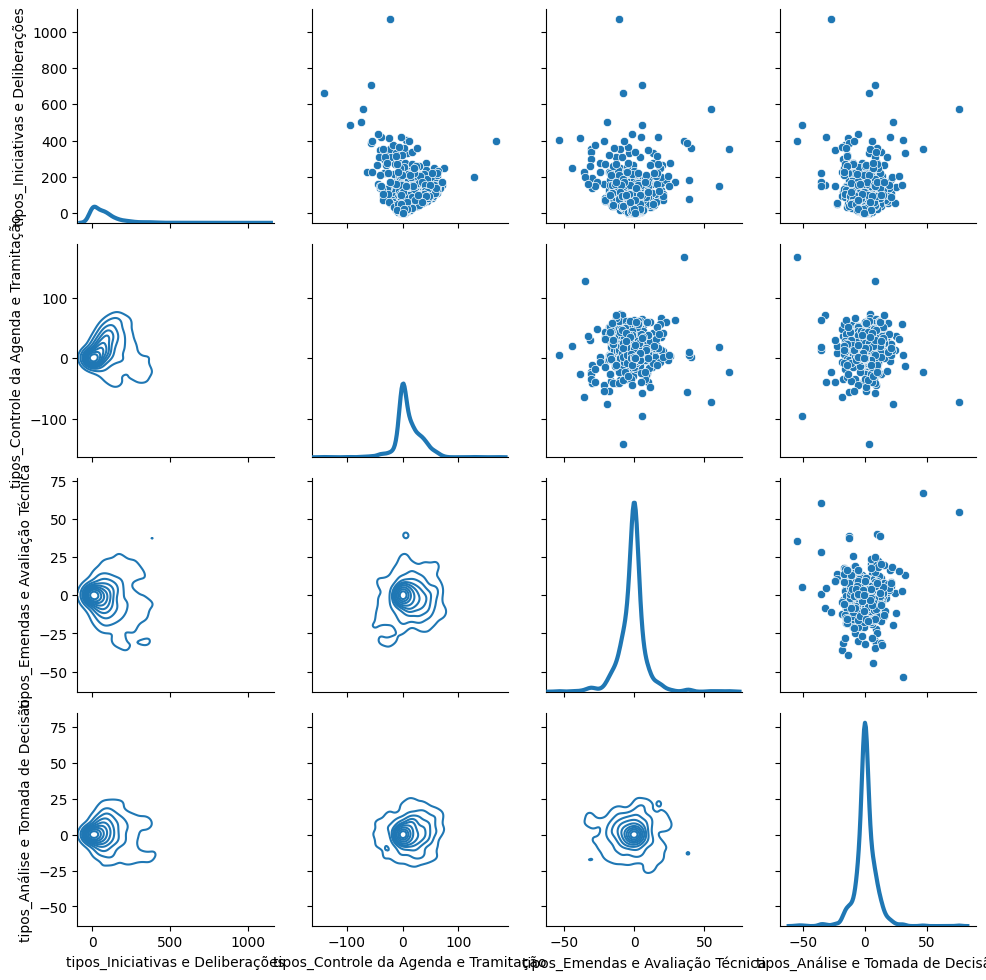

In [13]:
g = sns.PairGrid(df_pca_tipos)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False)

Parameter: {'n_clusters': 2} Score 0.6447285185590901
Parameter: {'n_clusters': 5} Score 0.5386367739990229
Parameter: {'n_clusters': 10} Score 0.500115239266171
Parameter: {'n_clusters': 20} Score 0.4310464634827047


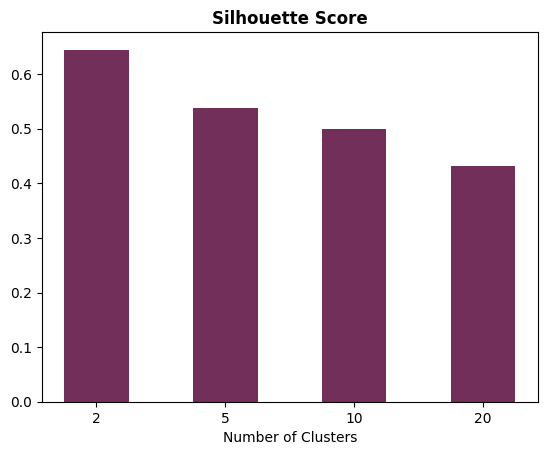

In [14]:
plots.plot_silhouette_score(df_pca_tipos, parameters=[2,5,10,20])

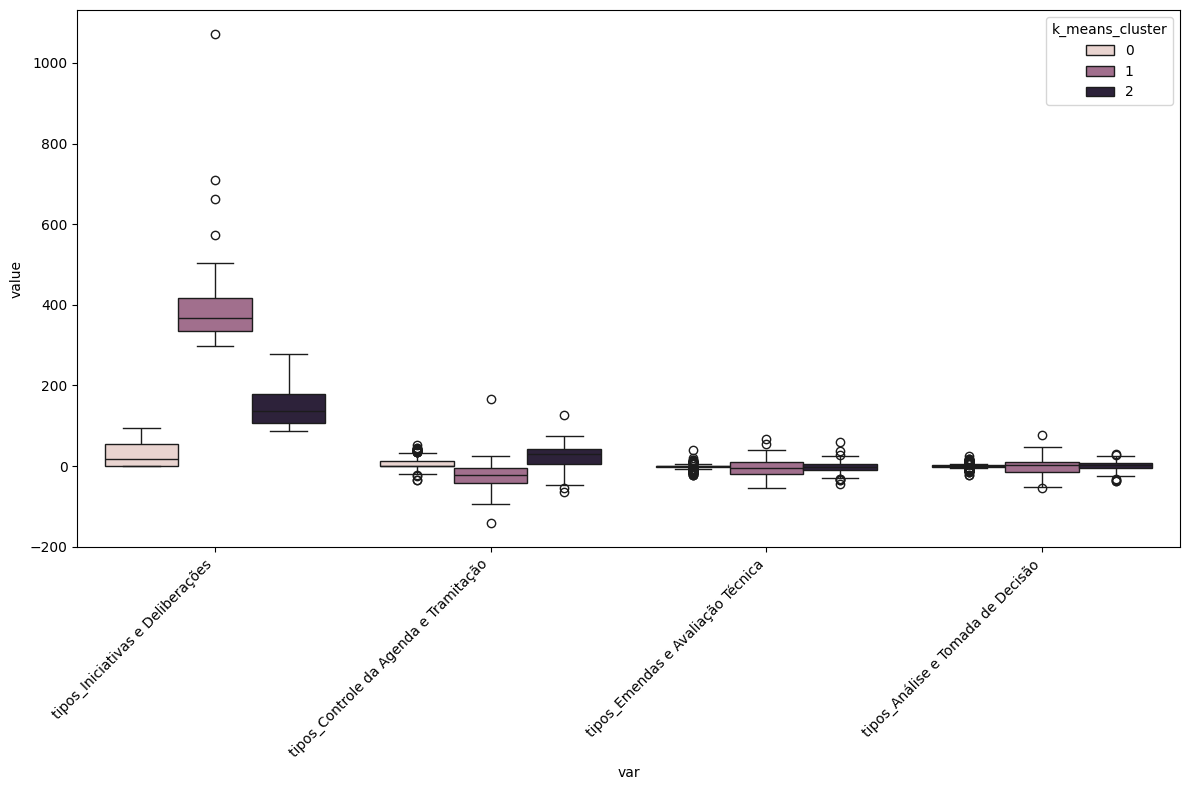

In [16]:
df_cluster = cluster_dataframe(df_pca_tipos, k_value=3)

cols = ["k_means_cluster"] #"gmm_cluster, "dbscan_cluster",
for col in cols:
    df_c_melted = melt_df(df_cluster, val_columns=df_pca_tipos.columns, cluster_column=col)
    plot_melted_df(df_c_melted, hue_col=col)

## Cluster Merge

In [80]:
df_pca_final = df_pca_tipos.join(df_pca_temas, how='inner').dropna()

Parameter: {'n_clusters': 2} Score 0.672248246717493
Parameter: {'n_clusters': 3} Score 0.4997242610145156
Parameter: {'n_clusters': 4} Score 0.48755987807244544
Parameter: {'n_clusters': 5} Score 0.4912052776658127
Parameter: {'n_clusters': 10} Score 0.4898120250663218


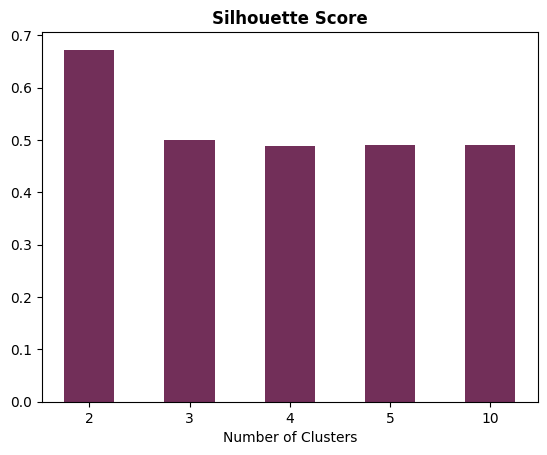

In [81]:
plots.plot_silhouette_score(df_pca_final)

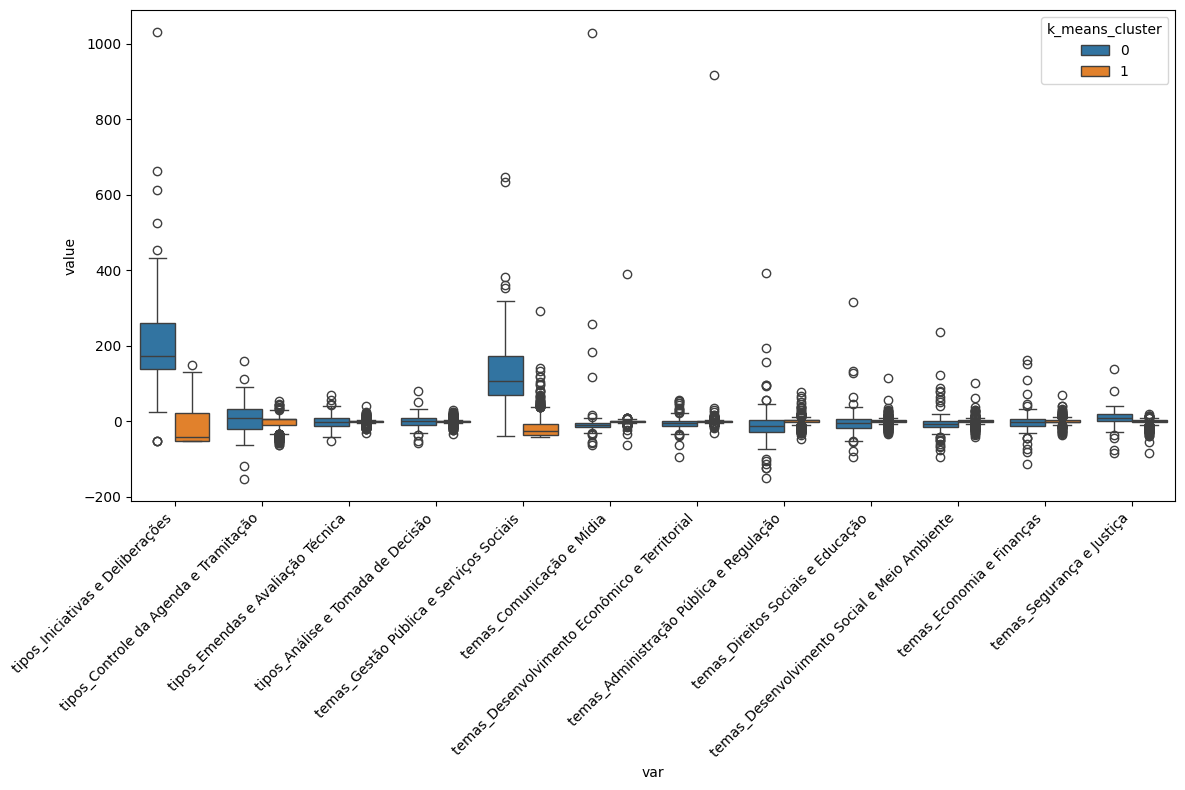

In [82]:
df_cluster = cluster_dataframe(df_pca_final, k_value=2)

cols = ["k_means_cluster"] #"gmm_cluster, "dbscan_cluster",
for col in cols:
    df_c_melted = melt_df(df_cluster, val_columns=df_pca_final.columns, cluster_column=col)
    plot_melted_df(df_c_melted, hue_col=col)

# df final

In [ ]:
ids_deps = df_deps["id"].unique()

df = pd.DataFrame()
df["id_dep"] = ids_deps

df.set_index('id_dep', inplace=True)

df_final = df.join(df_pca_tipos, how='inner').join(df_pca_temas, how='inner').dropna()